In [1]:
license = ""
secret = ""
nlp_secret = ""
aws_access_key = ""
aws_secret_key = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../../target/scala-2.12"

## Start Spark session

In [2]:
from sparkocr import start
import os 


if license:
    os.environ['JSL_OCR_LICENSE'] = license
    os.environ['SPARK_NLP_LICENSE'] = license

if aws_access_key:
    os.environ['AWS_ACCESS_KEY'] = aws_access_key
    os.environ['AWS_SECRET_ACCESS_KEY'] = aws_secret_key

extra_configurations = {
    "spark.extraListeners": "com.johnsnowlabs.license.LicenseLifeCycleManager"
}

spark = start(secret=secret,
              nlp_secret=nlp_secret,
              jar_path=spark_ocr_jar_path,
              nlp_internal="6.2.2",
              extra_conf=extra_configurations)

spark

Spark version: 3.5.0
Spark NLP version: 6.2.0
Spark NLP for Healthcare version: 6.2.2
Spark OCR version: 6.2.2

:: loading settings :: url = jar:file:/usr/local/lib/python3.11/dist-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-ed5522c8-f0e4-431e-b17b-2bf69bb0c06a;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;6.2.2 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-s3;1.12.500 in central
	found com.amazonaws#aws-java-sdk-kms;1.12.500 in central
	found com.amazonaws#aws-java-sdk-core;1.12.500 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazonaws#jmespath-java;1.12.500 in central
	found com.g

## Import transformers and annotators

In [3]:
import os
import sys
import shutil 
import pkg_resources

from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp_jsl
from sparknlp_jsl.annotator import *

import sparkocr
from sparkocr.transformers import *
from sparkocr.utils import *
from sparkocr.enums import *
from sparkocr.schemas import BinarySchema

from pyspark.ml import PipelineModel, Pipeline
from pyspark.sql.functions import *

print(f"Spark NLP version: {sparknlp.version()}")
print(f"Spark NLP internal version: {sparknlp_jsl.version()}")
print(f"Spark OCR version: {sparkocr.version()}")

/tmp/ipykernel_20625/3086732816.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


Spark NLP version: 6.2.0
Spark NLP internal version: 6.2.2
Spark OCR version: 6.2.2


## Load Dicom Files

In [4]:
midib_root_path = './../data/dicom/midib/*.dcm'

dicom_df = spark.read.format("binaryFile").load(midib_root_path)

dicom_df

path,modificationTime,length,content
file:/workspace/w...,2026-01-23 16:54:29,8179050,[00 00 00 00 00 0...
file:/workspace/w...,2026-01-23 16:54:29,7022298,[00 00 00 00 00 0...


  <h3>DICOM De-Identification (Text Detection Only)</h3>

  <p>
    This pipeline performs DICOM de-identification using only <b>text detection</b> (no OCR / NER).
    It detects text regions and masks them directly on the DICOM images.
  </p>

  <h3>Stages</h3>
  <ul>
    <li><b>DicomToImageV3</b> — extracts frames/images from the DICOM</li>
    <li><b>ImageTextDetector</b> — detects text and outputs bounding-box regions</li>
    <li><b>DicomDrawRegions</b> — renders (masks) the detected regions back onto the DICOM frames</li>
  </ul>

  <h3>Region Type</h3>
  <p>
    Since we are using <b>ImageTextDetector</b>, set:
    <b>setRegionType(V1)</b>
  </p>

In [5]:
dicom_to_image = DicomToImageV3() \
    .setInputCols(["content"]) \
    .setOutputCol("image_raw") \
    .setKeepInput(False)

text_detector = ImageTextDetector.pretrained("image_text_detector_mem_opt", "en", "clinical/ocr") \
    .setInputCol("image_raw") \
    .setOutputCol("text_regions") \
    .setScoreThreshold(0.7) \
    .setWithRefiner(True) \
    .setUseGPU(False) \
    .setWidth(0)

draw_regions = DicomDrawRegions() \
    .setInputCol("path") \
    .setInputRegionsCol("text_regions") \
    .setOutputCol("final_dicom") \
    .setAggCols(["path"]) \
    .setKeepInput(True) \
    .setRegionType(RegionType.V1)

stages = [dicom_to_image, text_detector, draw_regions]
                    
pipeline = PipelineModel(stages = stages)

image_text_detector_mem_opt download started this may take some time.
Approximate size to download 77.5 MB
image_text_detector_mem_opt download started this may take some time.
Approximate size to download 77.5 MB
Download done! Loading the resource.
No error


In [6]:
res_df = pipeline.transform(dicom_df).cache()
res_df.columns

/usr/local/lib/python3.11/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


['final_dicom', 'exception', 'path']

In [7]:
# display_dicom(df=res_df, fields="final_dicom", limit_frame=1, show_meta=True)

<h3>Using ImageTextDetectorV2 as Text Detection Stage</h3>

In [8]:
dicom_to_image = DicomToImageV3() \
    .setInputCols(["content"]) \
    .setOutputCol("image_raw") \
    .setKeepInput(False)

text_detector = ImageTextDetectorV2.pretrained("image_text_detector_v2", "en", "clinical/ocr") \
    .setInputCol("image_raw") \
    .setOutputCol("text_regions") \
    .setScoreThreshold(0.5) \
    .setTextThreshold(0.2) \
    .setSizeThreshold(10) \
    .setWithRefiner(True)

draw_regions = DicomDrawRegions() \
    .setInputCol("path") \
    .setInputRegionsCol("text_regions") \
    .setOutputCol("final_dicom") \
    .setAggCols(["path"]) \
    .setKeepInput(True) \
    .setRegionType(RegionType.V2)

stages = [dicom_to_image, text_detector, draw_regions]
                    
pipeline = PipelineModel(stages = stages)

image_text_detector_v2 download started this may take some time.
Approximate size to download 75.3 MB
image_text_detector_v2 download started this may take some time.
Approximate size to download 75.3 MB
Download done! Loading the resource.
No error


In [9]:
res_df = pipeline.transform(dicom_df).cache()
res_df.columns

['final_dicom', 'exception', 'path']

In [10]:
# display_dicom(df=res_df, fields="final_dicom", limit_frame=1, show_meta=True)

  <h2>DICOM De-Identification (NER Detection + Coordinate Generation)</h2>

  <p>
    This pipeline performs DICOM de-identification using <b>text detection, OCR, and NER</b>
    to precisely locate PHI in pixel data and redact it in place.
  </p>

  <h3>Stages</h3>
  <ul>
    <li><b>DicomToImageV3</b> — extracts images/frames from the DICOM</li>
    <li><b>ImageTextDetector / ImageTextDetectorV2 </b> — detects regions containing text in DICOM pixels</li>
    <li><b>ImageToTextV2 / ImageToTextV3</b> — extracts text from the detected regions (OCR). This is the final stage which requires images as input. After this stage, we drop the images.</li>
    <li><b>DocumentAssembler</b> — converts extracted text into a Document object (entry point to Healthcare NLP)</li>
    <li><b>SentenceDetector</b> — splits the Document into Sentence objects</li>
    <li><b>Tokenizer</b> — generates tokens required for NER processing</li>
    <li><b>PretrainedZeroShotNER</b> — detects PHI entities using an NER model</li>
    <li><b>NerConverterInternal</b> — filters and normalizes detected PHI entities</li>
    <li><b>PositionFinder</b> — generates pixel coordinates by aligning NER results with text detector regions</li>
    <li><b>DicomDrawRegions</b> — renders the final DICOM with PHI regions redacted in place</li>
  </ul>

<p>In the pipeline definition below we are not including DicomDrawRegions as this is an aggregation stage and will destroy intermediate results from the dataframe.</p>
</div>

In [11]:
dicom_to_image = DicomToImageV3() \
    .setInputCols(["content"]) \
    .setOutputCol("image_raw") \
    .setKeepInput(False)

text_detector = ImageTextDetector.pretrained("image_text_detector_mem_opt", "en", "clinical/ocr") \
    .setInputCol("image_raw") \
    .setOutputCol("text_regions") \
    .setScoreThreshold(0.7) \
    .setWithRefiner(True) \
    .setUseGPU(False) \
    .setWidth(0)

ocr = ImageToTextV2.pretrained("ocr_large_printed_v2", "en", "clinical/ocr") \
    .setRegionsColumn("text_regions") \
    .setInputCols(["image_raw"]) \
    .setOutputCol("text") \
    .setOutputFormat("text_with_positions") \
    .setGroupImages(False) \
    .setKeepInput(False) \
    .setUseGPU(False) \
    .setUseCaching(True)

p_document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("p_document") \
    .setCleanupMode("disabled")

p_sentencer = SentenceDetector()\
    .setInputCols(["p_document"])\
    .setOutputCol("p_sentence") \
    .setCustomBounds(["\n"]) \
    .setUseCustomBoundsOnly(False)

p_tokenizer = Tokenizer() \
    .setInputCols(["p_sentence"]) \
    .setOutputCol("p_token")

labels = ["DATE", "DOCTOR", "PATIENT"]
p_zeroshot_ner_deid_subentity_docwise_medium = PretrainedZeroShotNER().pretrained("zeroshot_ner_deid_subentity_docwise_medium", "en", "clinical/models")\
    .setInputCols("p_sentence", "p_token")\
    .setOutputCol("p_zeroshot_ner_deid_subentity_docwise_medium")\
    .setPredictionThreshold(0.5)\
    .setLabels(labels)

p_zeroshot_ner_deid_subentity_docwise_medium_ner_converter = NerConverterInternal()\
    .setInputCols("p_sentence", "p_token", "p_zeroshot_ner_deid_subentity_docwise_medium")\
    .setOutputCol("p_zeroshot_ner_deid_subentity_docwise_medium_ner_chunk") \
    .setThreshold(0.80)

position_finder = PositionFinder() \
    .setInputCols("p_zeroshot_ner_deid_subentity_docwise_medium_ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions") \
    .setSmoothCoordinates(True) \
    .setIgnoreSchema(True)

stages = [
    dicom_to_image,
    text_detector,
    ocr,
    p_document_assembler,
    p_sentencer,
    p_tokenizer,
    p_zeroshot_ner_deid_subentity_docwise_medium,
    p_zeroshot_ner_deid_subentity_docwise_medium_ner_converter,
    position_finder
]

pipeline = Pipeline(stages = stages)

image_text_detector_mem_opt download started this may take some time.
Approximate size to download 77.5 MB
ocr_large_printed_v2 download started this may take some time.
Approximate size to download 1.3 GB
Download done! Loading the resource.
zeroshot_ner_deid_subentity_docwise_medium download started this may take some time.
Approximate size to download 678.7 MB
[ | ]zeroshot_ner_deid_subentity_docwise_medium download started this may take some time.
Approximate size to download 678.7 MB
[ / ]Download done! Loading the resource.
[OK!]


In [12]:
res_df = pipeline.fit(dicom_df).transform(dicom_df).cache()
res_df.columns

['pagenum',
 'frame_dims',
 'path',
 'modificationTime',
 'length',
 'text_regions',
 'text',
 'confidence',
 'positions',
 'exception',
 'p_document',
 'p_sentence',
 'p_token',
 'p_zeroshot_ner_deid_subentity_docwise_medium',
 'p_zeroshot_ner_deid_subentity_docwise_medium_ner_chunk',
 'coordinates']

In [13]:
res_df.select("text").show(10, False)

17:18:16, INFO Run DicomToImageV3                                   (0 + 2) / 2]
17:18:16, INFO Run DicomToImageV3
17:18:21, INFO DicomToImageV3: Number of frames: 1
17:18:21, INFO DicomToImageV3: Number of frames To Extract: 0
17:18:21, INFO DicomToImageV3: Extracting All Frames.
17:18:21, INFO DicomToImageV3: Number of frames: 1
17:18:21, INFO DicomToImageV3: Number of frames To Extract: 0
17:18:21, INFO DicomToImageV3: Extracting All Frames.
17:18:21, INFO Error during overlay extraction: Traceback (most recent call last):
File "/usr/local/lib/python3.11/dist-packages/sparkocr/transformers/dicom/dicom_to_image_v3.py", line 239, in add_image
arr = arr + ds.overlay_array(0x6000)
^^^^^^^^^^^^^^^^^^^^^^^^
return get_overlay_array(self, group)
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
raise AttributeError(
AttributeError: Unable to convert the overlay data as the following required elements are missing from the dataset: OverlayData, OverlayBitsAllocated, OverlayRows, OverlayColumns
17:18:21, INFO E

Using CPUs


+-----------------------------------------------------+
|text                                                 |
+-----------------------------------------------------+
|EDWARDS WILLIAM [M] 05.26.2019\nDOB: 03.26.1938\nL110|
|L:\nONEAL DARRELL [U] 04.13.2012\nDOB: 02.19.1940    |
+-----------------------------------------------------+



In [14]:
res_df.select(F.explode("p_sentence").alias("Sentence")).show(100, False)

+----------------------------------------------------------------------+
|Sentence                                                              |
+----------------------------------------------------------------------+
|{document, 0, 29, EDWARDS WILLIAM [M] 05.26.2019, {sentence -> 0}, []}|
|{document, 31, 45, DOB: 03.26.1938, {sentence -> 1}, []}              |
|{document, 47, 50, L110, {sentence -> 2}, []}                         |
|{document, 0, 1, L:, {sentence -> 0}, []}                             |
|{document, 3, 30, ONEAL DARRELL [U] 04.13.2012, {sentence -> 1}, []}  |
|{document, 32, 46, DOB: 02.19.1940, {sentence -> 2}, []}              |
+----------------------------------------------------------------------+



In [15]:
res_df.select(F.explode("p_zeroshot_ner_deid_subentity_docwise_medium_ner_chunk").alias("Detected NER")).show(10, False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Detected NER                                                                                                                                                                      |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{chunk, 0, 14, EDWARDS WILLIAM, {entity -> PATIENT, confidence -> 0.9195272, ner_source -> p_zeroshot_ner_deid_subentity_docwise_medium_ner_chunk, chunk -> 0, sentence -> 0}, []}|
|{chunk, 20, 29, 05.26.2019, {entity -> DATE, confidence -> 0.9955799, ner_source -> p_zeroshot_ner_deid_subentity_docwise_medium_ner_chunk, chunk -> 1, sentence -> 0}, []}       |
|{chunk, 36, 45, 03.26.1938, {entity -> DATE, confidence -> 0.99549097, ner_source -> p_zerosho

In [16]:
res_df.select(F.explode("coordinates").alias("PHI Regions")).show(100, False)

+--------------------------------------------------------------+
|PHI Regions                                                   |
+--------------------------------------------------------------+
|{0, 0, 15.999999, 12.0, 346.00003, 46.0, 0.0, 0, 0.0, false}  |
|{1, 0, 477.33337, 12.0, 230.66663, 46.0, 0.0, 0, 0.0, false}  |
|{2, 0, 128.66666, 62.0, 225.33334, 40.0, 0.0, 0, 0.0, false}  |
|{0, 0, 990.0, 1912.0, 291.5714, 48.0, 0.0, 0, 0.0, false}     |
|{1, 0, 1393.7144, 1912.0, 224.28564, 48.0, 0.0, 0, 0.0, false}|
|{2, 0, 1104.0, 1960.0, 228.0, 44.0, 0.0, 0, 0.0, false}       |
+--------------------------------------------------------------+



In [17]:
draw_regions = DicomDrawRegions() \
    .setInputCol("path") \
    .setInputRegionsCol("coordinates") \
    .setOutputCol("final_dicom") \
    .setAggCols(["path"]) \
    .setKeepInput(True) \
    .setRegionType(RegionType.Coordinate)

No error


In [18]:
final_res = draw_regions.transform(res_df)
final_res.columns

['final_dicom', 'exception', 'path']

In [19]:
# display_dicom(df=final_res, fields="final_dicom", limit_frame=1, show_meta=True)

<h3>Visualization-Only Pipeline (Not for Production Use)</h3>

<p><b>Note:</b> This is a quick hack to show results side-by-side so you can visually understand how de-identification works. It should <b>not</b> be used in a real production use case.</p>

<p>
  In this example, we intentionally <b>keep the images after the OCR stage</b>. We don’t actually need to keep them for the pipeline,
  but we retain them so we can display both the <b>original</b> and the <b>de-identified</b> output.
</p>

<p>
  Since we want to render coordinates on something, we also need an image to draw on. In a typical production setup, we would
  <b>drop the image column</b> after extracting regions/text, and during rendering we would <b>reload the DICOM from its file path</b>.
  That means there is usually <b>no need to keep images in memory</b>.
</p>

<p>
  For visualization, we also use <b>ImageDrawRegions</b> instead of <b>DicomDrawRegions</b>, so we can create a copy of the image
  with PHI redacted using the generated coordinates.
</p>


In [20]:
dicom_to_image = DicomToImageV3() \
    .setInputCols(["content"]) \
    .setOutputCol("image_raw") \
    .setKeepInput(False)

text_detector = ImageTextDetector.pretrained("image_text_detector_mem_opt", "en", "clinical/ocr") \
    .setInputCol("image_raw") \
    .setOutputCol("text_regions") \
    .setScoreThreshold(0.7) \
    .setWithRefiner(True) \
    .setUseGPU(False) \
    .setWidth(0)

ocr = ImageToTextV3() \
    .setInputCols(["image_raw", "text_regions"]) \
    .setOutputCol("text")

p_document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("p_document") \
    .setCleanupMode("disabled")

p_sentencer = SentenceDetector()\
    .setInputCols(["p_document"])\
    .setOutputCol("p_sentence") \
    .setCustomBounds(["\n"]) \
    .setUseCustomBoundsOnly(False)

p_tokenizer = Tokenizer() \
    .setInputCols(["p_sentence"]) \
    .setOutputCol("p_token")

labels = ["DATE", "DOCTOR", "PATIENT"]
p_zeroshot_ner_deid_subentity_docwise_medium = PretrainedZeroShotNER().pretrained("zeroshot_ner_deid_subentity_docwise_medium", "en", "clinical/models")\
    .setInputCols("p_sentence", "p_token")\
    .setOutputCol("p_zeroshot_ner_deid_subentity_docwise_medium")\
    .setPredictionThreshold(0.5)\
    .setLabels(labels)

p_zeroshot_ner_deid_subentity_docwise_medium_ner_converter = NerConverterInternal()\
    .setInputCols("p_sentence", "p_token", "p_zeroshot_ner_deid_subentity_docwise_medium")\
    .setOutputCol("p_zeroshot_ner_deid_subentity_docwise_medium_ner_chunk") \
    .setThreshold(0.80)

position_finder = PositionFinder() \
    .setInputCols("p_zeroshot_ner_deid_subentity_docwise_medium_ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions") \
    .setSmoothCoordinates(True) \
    .setIgnoreSchema(True)

draw_regions = ImageDrawRegions() \
  .setInputCol("image_raw") \
  .setInputRegionsCol("coordinates") \
  .setRectColor(Color.black) \
  .setFilledRect(True) \
  .setOutputCol("image_with_regions")

stages = [
    dicom_to_image,
    text_detector,
    ocr,
    p_document_assembler,
    p_sentencer,
    p_tokenizer,
    p_zeroshot_ner_deid_subentity_docwise_medium,
    p_zeroshot_ner_deid_subentity_docwise_medium_ner_converter,
    position_finder,
    draw_regions
]

pipeline = Pipeline(stages = stages)

image_text_detector_mem_opt download started this may take some time.
Approximate size to download 77.5 MB
zeroshot_ner_deid_subentity_docwise_medium download started this may take some time.
Approximate size to download 678.7 MB
[OK!]


In [21]:
res_df = pipeline.fit(dicom_df).transform(dicom_df).cache()
res_df.columns

['image_raw',
 'pagenum',
 'frame_dims',
 'path',
 'modificationTime',
 'length',
 'text_regions',
 'text',
 'positions',
 'p_document',
 'p_sentence',
 'p_token',
 'p_zeroshot_ner_deid_subentity_docwise_medium',
 'p_zeroshot_ner_deid_subentity_docwise_medium_ner_chunk',
 'coordinates',
 'image_with_regions',
 'exception']

17:19:14, INFO Run DicomToImageV3
17:19:14, INFO DicomToImageV3: Number of frames: 1
17:19:14, INFO DicomToImageV3: Number of frames To Extract: 0
17:19:14, INFO DicomToImageV3: Extracting All Frames.
17:19:14, INFO Error during overlay extraction: Traceback (most recent call last):
File "/usr/local/lib/python3.11/dist-packages/sparkocr/transformers/dicom/dicom_to_image_v3.py", line 239, in add_image
arr = arr + ds.overlay_array(0x6000)
^^^^^^^^^^^^^^^^^^^^^^^^
return get_overlay_array(self, group)
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
raise AttributeError(
AttributeError: Unable to convert the overlay data as the following required elements are missing from the dataset: OverlayData, OverlayBitsAllocated, OverlayRows, OverlayColumns
17:19:14, INFO Run DicomToImageV3
17:19:14, INFO DicomToImageV3: Number of frames: 1
17:19:14, INFO DicomToImageV3: Number of frames To Extract: 0
17:19:14, INFO DicomToImageV3: Extracting All Frames.
17:19:14, INFO Error during overlay extraction: Traceback (most

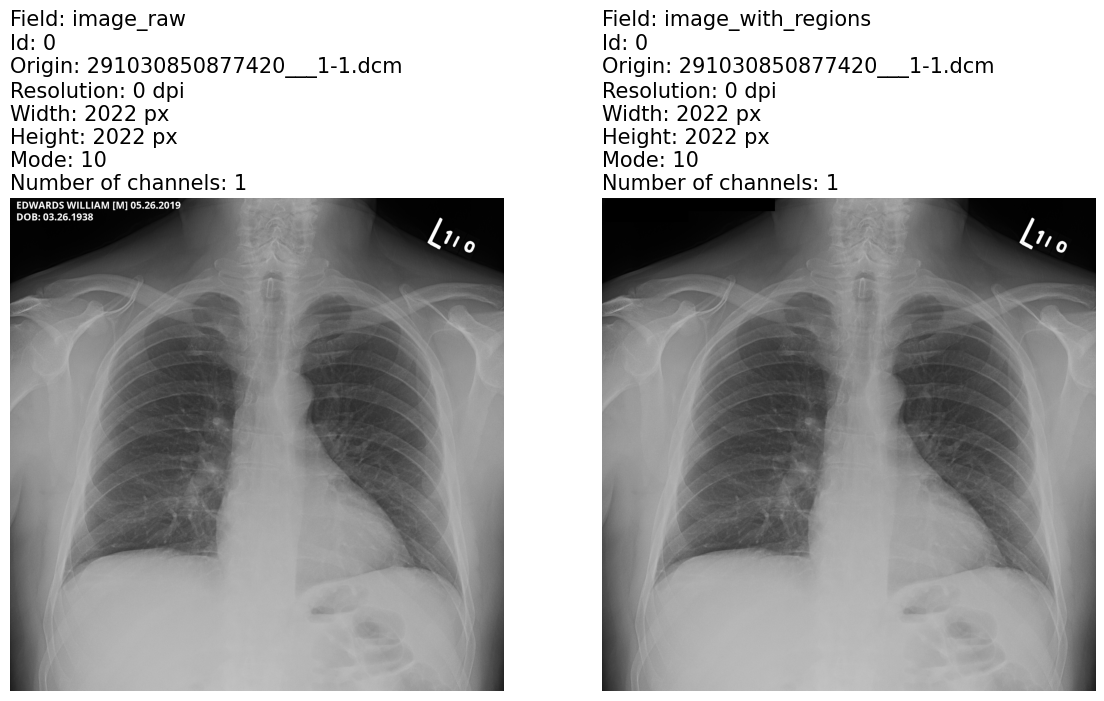

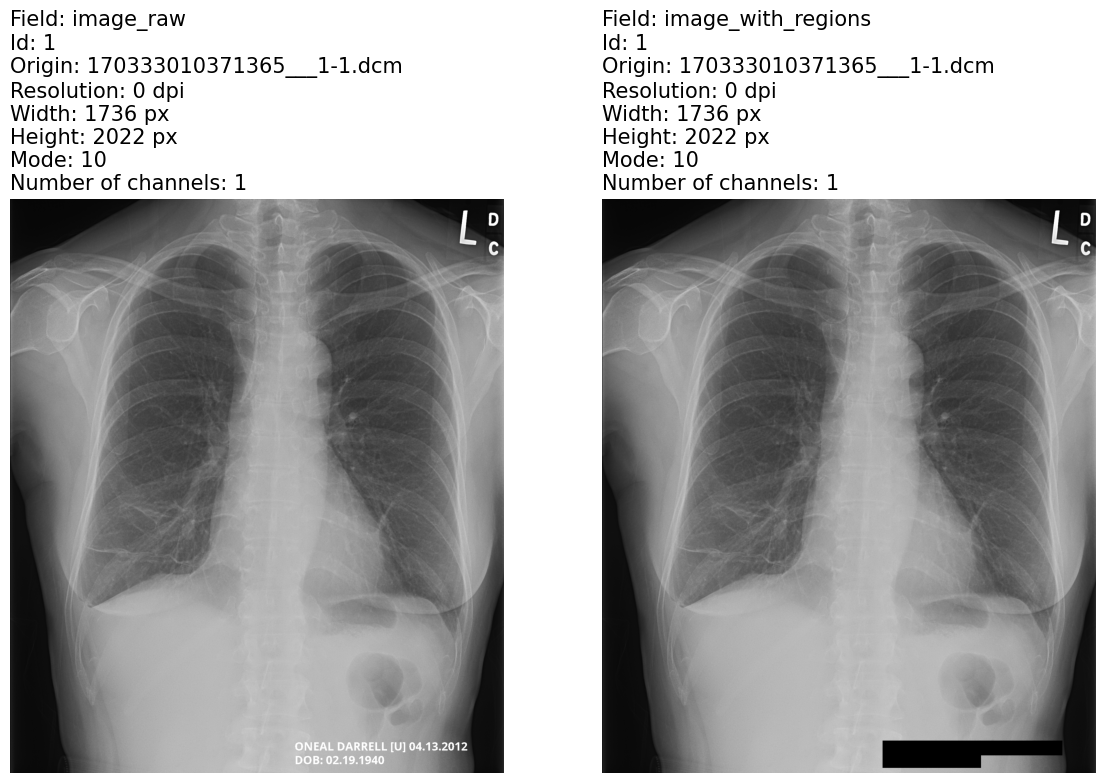

In [22]:
display_images_horizontal(df=res_df, fields="image_raw, image_with_regions", show_meta=True)

<h2>Switch TextDetection to ImageTextDetectorV2 and OCR to ImageToTextV3</h2>

<p>
  This section shows the end-to-end DICOM de-identification pipeline using
  <b>ImageTextDetectorV2</b> for text detection and <b>ImageToTextV3</b> for OCR,
  with final redaction rendered back into the DICOM using <b>DicomDrawRegions</b>.
</p>

<h3>End-to-End Pipeline</h3>
<ul>
  <li><b>DicomToImageV3</b> — extracts images/frames from the DICOM</li>
  <li><b>ImageTextDetectorV2</b> — detects text regions in DICOM pixel data</li>
  <li><b>ImageToTextV3</b> — performs OCR on detected text regions</li>
  <li><b>DocumentAssembler</b> — converts OCR text into Document objects</li>
  <li><b>SentenceDetector</b> — splits documents into sentences</li>
  <li><b>Tokenizer</b> — generates tokens for NER</li>
  <li><b>PretrainedZeroShotNER</b> — detects PHI entities in text</li>
  <li><b>NerConverterInternal</b> — filters PHI entities for redaction</li>
  <li><b>PositionFinder</b> — generates pixel coordinates from NER + text regions</li>
  <li><b>DicomDrawRegions</b> — renders the final DICOM with PHI redacted in place</li>
</ul>

In [23]:
dicom_to_image = DicomToImageV3() \
    .setInputCols(["content"]) \
    .setOutputCol("image_raw") \
    .setKeepInput(False)

text_detector = ImageTextDetectorV2.pretrained("image_text_detector_v2", "en", "clinical/ocr") \
    .setInputCol("image_raw") \
    .setOutputCol("text_regions") \
    .setScoreThreshold(0.5) \
    .setTextThreshold(0.2) \
    .setSizeThreshold(10) \
    .setWithRefiner(True)

ocr = ImageToTextV3() \
    .setInputCols(["image_raw", "text_regions"]) \
    .setOutputCol("text")

p_document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("p_document") \
    .setCleanupMode("disabled")

p_sentencer = SentenceDetector()\
    .setInputCols(["p_document"])\
    .setOutputCol("p_sentence") \
    .setCustomBounds(["\n"]) \
    .setUseCustomBoundsOnly(False)

p_tokenizer = Tokenizer() \
    .setInputCols(["p_sentence"]) \
    .setOutputCol("p_token")

labels = ["DATE", "DOCTOR", "PATIENT"]
p_zeroshot_ner_deid_subentity_docwise_medium = PretrainedZeroShotNER().pretrained("zeroshot_ner_deid_subentity_docwise_medium", "en", "clinical/models")\
    .setInputCols("p_sentence", "p_token")\
    .setOutputCol("p_zeroshot_ner_deid_subentity_docwise_medium")\
    .setPredictionThreshold(0.5)\
    .setLabels(labels)

p_zeroshot_ner_deid_subentity_docwise_medium_ner_converter = NerConverterInternal()\
    .setInputCols("p_sentence", "p_token", "p_zeroshot_ner_deid_subentity_docwise_medium")\
    .setOutputCol("p_zeroshot_ner_deid_subentity_docwise_medium_ner_chunk") \
    .setThreshold(0.80)

position_finder = PositionFinder() \
    .setInputCols("p_zeroshot_ner_deid_subentity_docwise_medium_ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions") \
    .setSmoothCoordinates(True) \
    .setIgnoreSchema(True)

draw_regions = DicomDrawRegions() \
    .setInputCol("path") \
    .setInputRegionsCol("coordinates") \
    .setOutputCol("final_dicom") \
    .setAggCols(["path"]) \
    .setKeepInput(True) \
    .setRegionType(RegionType.Coordinate)

stages = [
    dicom_to_image,
    text_detector,
    ocr,
    p_document_assembler,
    p_sentencer,
    p_tokenizer,
    p_zeroshot_ner_deid_subentity_docwise_medium,
    p_zeroshot_ner_deid_subentity_docwise_medium_ner_converter,
    position_finder,
    draw_regions
]

pipeline = Pipeline(stages = stages)

image_text_detector_v2 download started this may take some time.
Approximate size to download 75.3 MB
zeroshot_ner_deid_subentity_docwise_medium download started this may take some time.
Approximate size to download 678.7 MB
[OK!]
No error


In [24]:
res_df = pipeline.fit(dicom_df).transform(dicom_df).cache()
res_df.columns

/usr/local/lib/python3.11/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


['final_dicom', 'exception', 'path']

In [25]:
# display_dicom(df=res_df, fields="final_dicom", limit_frame=1, show_meta=True)

## Save Dicom File To Disk

In [26]:
root_path = "./dicom_deid_output"

os.makedirs(root_path, exist_ok=True)

for item in res_df.select("path", "final_dicom").toLocalIterator():
    data = item.asDict()
    filename = os.path.basename(data["path"])

    file_out_path = os.path.join(root_path, filename)

    with open(file_out_path, "wb") as dicom_out:
        dicom_out.write(data["final_dicom"])

17:19:43, INFO Run DicomToImageV3
17:19:43, INFO DicomToImageV3: Number of frames: 1
17:19:43, INFO DicomToImageV3: Number of frames To Extract: 0
17:19:43, INFO DicomToImageV3: Extracting All Frames.
17:19:43, INFO Error during overlay extraction: Traceback (most recent call last):
File "/usr/local/lib/python3.11/dist-packages/sparkocr/transformers/dicom/dicom_to_image_v3.py", line 239, in add_image
arr = arr + ds.overlay_array(0x6000)
^^^^^^^^^^^^^^^^^^^^^^^^
return get_overlay_array(self, group)
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
raise AttributeError(
AttributeError: Unable to convert the overlay data as the following required elements are missing from the dataset: OverlayData, OverlayBitsAllocated, OverlayRows, OverlayColumns
17:19:43, INFO Run DicomToImageV3
17:19:43, INFO DicomToImageV3: Number of frames: 1
17:19:43, INFO DicomToImageV3: Number of frames To Extract: 0
17:19:43, INFO DicomToImageV3: Extracting All Frames.
17:19:43, INFO Error during overlay extraction: Traceback (most

In [27]:
shutil.rmtree(root_path)